In [1]:
import sys
import os
import numpy as np
import time
from imp import reload

# Set the working directory to the AutomatedCE folder so we have access to L1-L4 modules
resp = os.getcwd()
if 'testing' in resp[-7:]:
    os.chdir(os.path.abspath(os.path.join(os.getcwd(), '..')))
    print(f"new directory is: {os.getcwd()}")

new directory is: C:\Users\NikonTE300CE\Desktop\Barracuda\AutomatedCE


# Test 1: DAQ Controllers


In [2]:
from L1 import DAQControllers
reload(DAQControllers)

<module 'L1.DAQControllers' from 'C:\\Users\\NikonTE300CE\\Desktop\\Barracuda\\AutomatedCE\\L1\\DAQControllers.py'>

## National Instruments DAQ

Tests:
1. Initialize the DAQ
2. Set an analog output Voltage
3. Read an analog input voltage
4. Set an digitalouput voltage

In [9]:
ni = DAQControllers.NiDaq()

all_data = []
def print_data(data,time,channels,*args):
    print(f"Total samples: {len(data[0])}, average: {np.mean(data)} V ")

def add_data(data,time,channels,*args):
    global all_data
    all_data.append(data)
    
#ni.add_callback(print_data, ['ai0'], "wave",())
ni.add_callback(print_data, ['ai5'],"wave",())
ni.add_callback(add_data,['ai5'],"wave",())
print("Initialize complete...")

Initialize complete...


In [10]:
ni.add_analog_input('ai5', terminal_config="DIFF")
ni.set_sampling_frequency(1000)
ni.start_measurement()
time.sleep(.1)
ni.stop_measurement()
print("\nThere should be 100 samples read in 0.1 s \n")

Total samples: 100, average: 1.5334802288257883 V 
There should be 100 samples read in 0.1 s 




In [42]:
ni.add_analog_output('ao0')
ni.set_channel_voltage('ao0',0.05)
ni.start_voltage()
print("Analog output voltage set, measure channel ao0. \nMeter should read 50 mV")

Analog output voltage set, measure channel ao0. 
Meter should read 50 mV


In [11]:
all_data

[[array([[1.52494896, 1.53401444, 1.54000414, 1.54356558, 1.54194674,
          1.53433821, 1.52818663, 1.5205781 , 1.52268259, 1.53029112,
          1.5364427 , 1.54502253, 1.54518442, 1.53773777, 1.53029112,
          1.52333012, 1.52203505, 1.52802475, 1.537414  , 1.54324181,
          1.54469877, 1.54097544, 1.53352879, 1.52203505, 1.52138752,
          1.52333012, 1.53336691, 1.54162298, 1.54550818, 1.54453688,
          1.53336691, 1.52737722, 1.52430143, 1.5215494 , 1.54146109,
          1.54113733, 1.54518442, 1.54502253, 1.53757589, 1.52915794,
          1.52511084, 1.5215494 , 1.52543461, 1.5383853 , 1.54275616,
          1.54453688, 1.54550818, 1.53271938, 1.52397766, 1.52365389,
          1.52284447, 1.53077677, 1.54048979, 1.54388935, 1.54259428,
          1.53498575, 1.52575838, 1.52187317, 1.52365389, 1.52818663,
          1.53968037, 1.54307993, 1.54421311, 1.53628082, 1.52883417,
          1.52171129, 1.52284447, 1.52527273, 1.5364427 , 1.54291805,
          1.54680325

In [45]:
channel = 'p1.1'
ni.add_do_channel(channel)
ni.set_do_channel(channel, True)
ni.update_do_channels()
print(f"Digital output on {ni.interpret_do_channels(channel)} should read digital High")

Digital output on port1/line1 should read digital High


# Test 2: Linear Motion Utilities

tests:
1. Home to Zero position
2. Read and set position
3. Stop movement

In [37]:
from L1 import Controllers
from L2 import ZControl
reload(ZControl)
reload(Controllers)

 Change System Config setting if thorlabs is needed. 
 Change System Config setting if thorlabs is needed. 


<module 'L1.Controllers' from 'C:\\Users\\Luke\\Desktop\\Barracuda\\AutomatedCE\\L1\\Controllers.py'>

In [38]:
unit_scalars = {'mm':1, "um":1000}
# Check Stop Capabilities
def check_z_stop(z, units='mm'):
    pos = z.read_z()
    travel = 4 * unit_scalars[units]
    z.set_rel_z(travel)
    time.sleep(0.2)
    z.stop()
    z.read_z()

    print(f"Motor should stop moving before it reaches {pos+travel} {units}")
    print(f"Final position: {z.read_z()} {units}")

In [39]:
# Check Homing Capability
def check_z_homing(z):
    z.homing()
    print("Thorlabs should be at the 0 mm height, powerstep at 29.75 mm")

In [40]:
# Check Movment capabilities 
def check_z_movement(z, units = 'mm'):
    
    travel = 0.05 * unit_scalars[units]
    pos = z.read_z()
    z.set_rel_z(travel)
    time.sleep(2)
    final = z.read_z()

    print(f"Initial position was {pos} {units}, after move: {final} {units}")
    assert pos != final, print("Check Z Stage, it appears it did not move")

### Thorlab Kinesis Motor

In [39]:
ser_num = '49125264'
z = ZControl.KinesisZ(ser_num,'zstage')
z.startup()
print("Thorlabs Initialized...")


Thorlabs Initialized...


In [68]:
check_z_homing(z)

TypeError: check_z_homing() takes 1 positional argument but 2 were given

In [66]:
check_z_movement(z, 'mm')

Initial position was 1.0 um, after move: 51.0 um


In [70]:
check_z_stop(z, 'mm')

Motor should stop moving before it reaches 4051.0 um
Final position: 612.6 um


In [71]:
z.shutdown()

### Arduino PowerStep Motion

In [12]:
ctl = Controllers.ArduinoController("COM7")
ctl.open()
z = ZControl.ArduinoZ(ctl, 'zstage')
z.startup()

In [14]:
check_z_homing(z)

Thorlabs should be at the 0 mm height, powerstep at 29.75 mm


In [15]:
z.set_z(25)
z.wait_for_move()
check_z_movement(z)

Initial position was 25.0 mm, after move: 25.05 mm


In [16]:
check_z_stop(z)

Motor should stop moving before it reaches 29.05 mm
Final position: 26.845 mm


In [17]:
z.shutdown()
ctl.close()

### Prior Z Motion

In [58]:
check_z_homing(z)

Thorlabs should be at the 0 mm height, powerstep at 29.75 mm


In [7]:
ctl = Controllers.PriorController("COM9")
ctl.open()
z = ZControl.PriorZ(ctl,'zstage')
z.startup()
z.min_z = -100000
z.max_z = 100000

In [8]:
check_z_movement(z, 'um')

Initial position was 4051.0 um, after move: 4101.0 um


In [9]:
check_z_stop(z, 'um')

Motor should stop moving before it reaches 8101.0 um
Final position: 4722.1 um


In [44]:
z.shutdown()
ctl.close()

In [45]:
from L1 import Controllers
from L2 import ZControl
reload(ZControl)
reload(Controllers)

 Change System Config setting if thorlabs is needed. 


<module 'L1.Controllers' from 'C:\\Users\\Luke\\Desktop\\Barracuda\\AutomatedCE\\L1\\Controllers.py'>

### Pycromanager Z Motion


In [46]:
config = r"C:\Users\Luke\Desktop\Barracuda\AutomatedCE\config\NikonEclipseTi-NoLight.cfg"
ctl = Controllers.PycromanagerController(config = config)
ctl.open()

In [47]:
z = ZControl.PycromanagerZ(ctl,'zstage')
z.startup()

In [48]:
check_z_movement(z, 'mm')

Initial position was 0.0 mm, after move: 0.049925000743940476 mm


In [49]:
check_z_stop(z, 'mm')

Motor should stop moving before it reaches 4.049900000743568 mm
Final position: 0.04990000074356794 mm


In [ ]:
z.shutdown()
ctl.close()

# Test 3: XY Stage 

tests:
1. check acceleration and velocity settings
2. check movement
3. check stop


In [29]:
from L1 import Controllers
from L2 import XYControl
reload(XYControl)
reload(Controllers)

<module 'L1.Controllers' from 'C:\\Users\\Luke\\Desktop\\Barracuda\\AutomatedCE\\L1\\Controllers.py'>

In [3]:
def check_xy_motor_params(xy):
    a = xy.get_acceleration()
    v = xy.get_velocity()
    print(f"{a} mm/s/s, and {v} mm/s should be the stage parameters")
    
def check_xy_movement(xy):
    pos = xy.read_xy()
    xy.set_rel_xy([0.05,0.05])
    time.sleep(.1)
    final = xy.read_xy()
    print("Stage should move 50 microns towards the back of the scope"
         "and 50 microns towards the right.")
    print(f"Original pos {pos}, \nfinal pos {final} [mm,mm]")
    
    
def check_xy_stop(xy):
    input("Move stage to center, press enter when ready")
    pos = xy.read_xy()
    xy.set_rel_xy([5,5])
    xy.stop()
    final = xy.read_xy()
    xy.stop()
    print("Stage should stop before moving 5mm in x and y\n"
         f"Original pos: {pos}, final pos: {final}")
    if final[0]-pos[0] >=4.95 or final[1] - pos[1]>=4.95:
        print("Warning: Stage does not stop when asked!")
    else:
        print("Stage stopped before 5mm")
    

### Prior XY Stage

In [109]:
ctl = Controllers.PriorController('COM9')
ctl.open()
xy = XYControl.PriorXY(ctl,'xystage')
xy.startup()

In [51]:
check_xy_motor_params(xy)

114.2 mm/s/s, and 19.0 mm/s should be the stage parameters


In [121]:
check_xy_movement(xy)


Stage should move 50 microns towards the back of the scopeand 50 microns towards the right.
Original pos [6.679, -15.758], 
final pos [6.731, -15.706] [mm,mm]


In [119]:
check_xy_stop(xy)

Move stage to center, press enter when ready
Stage should stop before moving 5mm in x and yOriginal pos: [3.524, -18.93], final pos: [6.679, -15.758]
Stage stopped before 5mm


In [36]:
xy.shutdown()
ctl.close()

### MicroManager  Stage

In [30]:
config = r"C:\Users\Luke\Desktop\Barracuda\AutomatedCE\config\NikonEclipseTi-NoLight.cfg"
ctl = Controllers.PycromanagerController(config = config)
ctl.open()

In [32]:
xy = XYControl.PycromanagerXY(ctl,'xystage')
xy.startup()

In [33]:
xy.read_xy()

[0.25010000372678043, 0.2499000037238002]

In [34]:
check_xy_movement(xy)

Stage should move 50 microns towards the back of the scopeand 50 microns towards the right.
Original pos [0.25010000372678043, 0.2499000037238002], 
final pos [0.25010000372678043, 0.2499000037238002] [mm,mm]


In [35]:
check_xy_stop(xy)

Move stage to center, press enter when ready
Stage should stop before moving 5mm in x and y
Original pos: [0.3001000044718385, 0.29990000446885823], final pos: [0.3001000044718385, 0.29990000446885823]
Stage stopped before 5mm


In [28]:
xy.shutdown()
ctl.close()



# Test 4: Capillary Pressure Control
test:
1. Turn Pressure On
2. Turn Vacuum On


In [29]:
os.path.isfile(r'C:\Users\Luke\Desktop\Barracuda\AutomatedCE\L1\MicroControlServer.py')

True

In [34]:
from L1.Util import get_system_var
conda_path = sys.executable.split('CEpy37')[0]
PYTHON2_PATH = os.path.join(conda_path, get_system_var('python2path')[0]) # r"\CEpy27\python.exe"
os.path.isfile(PYTHON2_PATH)

True

In [33]:
get_system_var('python2path')

['CEpy27\\python.exe']

In [129]:
from L1 import Controllers
from L2 import PressureControl
reload(PressureControl)
reload(Controllers)

<module 'L1.Controllers' from 'C:\\Users\\NikonTE300CE\\Desktop\\Barracuda\\AutomatedCE\\L1\\Controllers.py'>

In [141]:
def check_p_pressure(p):
    p.rinse_pressure()
    input("The line should be pressurized, verify and press enter to stop")
    p.release()
    return

def check_p_vacuum(p):
    p.rinse_vacuum()
    input("The line should be under vacuum, verify and press enter to stop")
    p.release()
    return


In [131]:
ctl = Controllers.ArduinoController('COM8')
ctl.open()
p = PressureControl.ArduinoPressure(ctl,'outletpressure')
p.startup()

In [140]:
check_p_pressure(p)

The line should be pressurized, verify and press enter to stop


In [142]:
check_p_vacuum(p)

The line should be under vacuum, verify and press enter to stop


In [143]:
p.shutdown()
ctl.close()

In [20]:
conda_path = sys.executable.split('CEpy37')[0]
conda_path

'C:\\Users\\Luke\\Anaconda3\\envs\\'

In [24]:
ctl.open()

C:\Users\Luke\Desktop\Barracuda\AutomatedCE\L1\MicroControlServer.py


FileNotFoundError: [WinError 2] The system cannot find the file specified

# Test 5: High Voltage Power Supply

test:
1. Voltage changes
2. Voltage Stop (during timed)

**CAUTION:** For these tests, please verify that the system is correctly wired before running the tests.

**WARNING: HIGH VOLTAGE**


In [2]:
from L1 import DAQControllers
from L2 import HighVoltageControl
reload(HighVoltageControl)
reload(DAQControllers)

<module 'L1.DAQControllers' from 'C:\\Users\\NikonTE300CE\\Desktop\\Barracuda\\AutomatedCE\\L1\\DAQControllers.py'>

In [23]:
def check_voltage_and_stop(hv):
    hv.set_voltage(2)
    input("Ensure the CE setup is safe to apply voltage, press enter when ready")
    hv.start()
    time.sleep(1)
    input(f"Voltage set to {2} and reading {hv.get_voltage():.3f} kV, check gauge if this is correct, press enter to stop")
    
    hv.stop()
    time.sleep(1)
    print(f"Voltage should be at 0, reading {hv.get_voltage():.3f} kV")
    if not round(hv.get_voltage(),1) == 0:
        print ("WARNING: Voltage did not shut down")

### Spellman High Voltage Power Supply

In [3]:
ctl = DAQControllers.NiDaq()
ctl.open()
hv = HighVoltageControl.SpellmanPowerSupply(ctl,'hv',hv_ao='ao0',hv_ai='ai1', ua_ai='ai2')
hv.startup()

In [20]:
check_voltage_and_stop(hv)

Voltage set to 2 and reading 2.001 kV, check gauge if this is correct, press enter to stop
Voltage should be at 0, reading 0.011 kV


In [22]:
hv.shutdown()
ctl.close()

# Camera Testing

1. Snap an image
2. Start (and stop) a continuous acquisition
3. Change the exposure


In [13]:
from L1 import Controllers
from L2 import CameraControl
import matplotlib.pyplot as plt
import time

reload(Controllers)
reload(CameraControl)

<module 'L2.CameraControl' from 'C:\\Users\\Luke\\Desktop\\Barracuda\\AutomatedCE\\L2\\CameraControl.py'>

In [23]:
def check_single_snap(cam):
    print("An image will be snapped and should be displayed")
    f = plt.figure("Test Image")
    plt.imshow(cam.snap())
    
def record_image_arrival(img):
    print(f"Image has arrived, of type {type(img)}, and first value is {img[0][0]}")    
    
def check_multiple(cam):
    print("Following this message there should be several updates that an image has arrived")
    cam.add_callback(record_image_arrival)
    cam.continuous_snap()
    time.sleep(2)
    cam.stop()

def check_exposure(cam):
    print("The exposure will be set to 35 and should read 35 afterwards")
    cam.set_exposure(35)
    exp = cam.get_exposure()
    if round(exp) != 35:
        print("Warning: Exposure was not set")
    else:
        print("Exposure was set and read corrrectly")
        


### Pycromanager Camera

In [ ]:
CAMERA_CONFIG = r"C:\Users\Luke\Desktop\Barracuda\AutomatedCE\config\OrcaFlash.cfg"
ctl = Controllers.PycromanagerController(config = CAMERA_CONFIG)
ctl.open()
cam = CameraControl.PycromanagerControl(ctl, 'Camera')
cam.startup()

An image will be snapped and should be displayed


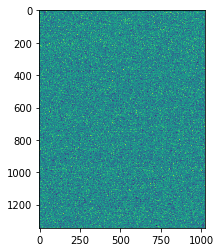

In [27]:
check_single_snap(cam)

In [28]:
check_multiple(cam)

Following this message there should be several updates that an image has arrived
Image has arrived, of type <class 'numpy.ndarray'>, and first value is 103
Image has arrived, of type <class 'numpy.ndarray'>, and first value is 102
Image has arrived, of type <class 'numpy.ndarray'>, and first value is 104
Image has arrived, of type <class 'numpy.ndarray'>, and first value is 100
Image has arrived, of type <class 'numpy.ndarray'>, and first value is 102
Image has arrived, of type <class 'numpy.ndarray'>, and first value is 104


In [29]:
check_exposure(cam)

The exposure will be set to 35 and should read 35 afterwards
Exposure was set and read corrrectly


In [30]:
cam.shutdown()
ctl.close()